## Cargamos los librerias y los datasets

In [265]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import log_loss, make_scorer, confusion_matrix
import seaborn as sns

In [78]:
train = pd.read_csv('train_completo.csv')
test = pd.read_csv('test_completo.csv')

## Implementacion de los modelos

La estrategía a seguir es entrenar disitintos modelos de clasificación y evaluar el desempeño de cada uno para despues tratar de mejorarlo. Los modelos seleccionados para este primer analisis son:
+ **Random Forest Classifier**

+ **KNNeighbors Classifier**

+ **Suport Vector Classifier**

+ **Gradient Boosting Classifier**


#### Preparamos los datos para implementar el modelo

In [4]:
y = train['fault_severity']
train.drop(['id', 'fault_severity'], axis=1, inplace=True)
X = train

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [17]:
# Funcion para entrenar cada modelo

def classifier_train(classifier, X_train, X_test, y_train, y_test):
    model_trained = classifier.fit(X_train, y_train)
    y_predict = model_trained.predict_proba(X_test)
    l_loss = log_loss(y_test, y_predict)
    score = model_trained.score(X_test, y_test)
    print('{}'.format(classifier))
    print('log_loss: {}'.format(l_loss))
    print('score: {}'.format(score))
    return model_trained

In [18]:
RF = RandomForestClassifier()
KNN = KNeighborsClassifier()
SVM = SVC(probability=True, class_weight='balanced')
GBC = GradientBoostingClassifier()

#### Random Forest

In [19]:
classifier_train(RF, X_train, X_test, y_train, y_test)

RandomForestClassifier()
log_loss: 0.9416207402730378
score: 0.7102234258632363


RandomForestClassifier()

#### KN-Neighbors

In [20]:
classifier_train(KNN, X_train, X_test, y_train, y_test)

KNeighborsClassifier()
log_loss: 2.7277852028770235
score: 0.6337169939065673


KNeighborsClassifier()

#### Suport Vector Classifier

In [21]:
classifier_train(SVM, X_train, X_test, y_train, y_test)

SVC(class_weight='balanced', probability=True)
log_loss: 0.7769804099494645
score: 0.5274204468517265


SVC(class_weight='balanced', probability=True)

#### Gradient Boosting Classifier

In [22]:
classifier_train(GBC, X_train, X_test, y_train, y_test)

GradientBoostingClassifier()
log_loss: 0.5878876639774616
score: 0.7244414353419093


GradientBoostingClassifier()

**Observaciones:**

Vemos que los algoritmos con mejor desempeño son GBC y SVC. Trataremos de mejorar SVC

Nos proponemos entrenar SVC ahora con un kernel gaussiano radial y un kernel sigmoid

In [23]:
SVM = SVC(kernel='rbf', probability=True, class_weight='balanced')
classifier_train(SVM, X_train, X_test, y_train, y_test)

SVC(class_weight='balanced', probability=True)
log_loss: 0.7769802693804098
score: 0.5274204468517265


SVC(class_weight='balanced', probability=True)

In [24]:
SVM = SVC(kernel='sigmoid', probability=True, class_weight='balanced')
classifier_train(SVM, X_train, X_test, y_train, y_test)

SVC(class_weight='balanced', kernel='sigmoid', probability=True)
log_loss: 0.8376458296832184
score: 0.2017603249830738


SVC(class_weight='balanced', kernel='sigmoid', probability=True)

Observamos que las modificaciones en el kernel no son significativas, en el caso de sigmoid el modelo empeora el rendimiento. Dado que el modelo con mejor desempeño es GBC, me propondré mejorarlo

## Matriz de confusion GBC

In [266]:
model_GBC = GBC.fit(X_train, y_train)

In [273]:
y_pred = model_GBC.predict(X_test)

In [278]:
cm_gbc = confusion_matrix(y_test, y_pred)
cm = 100*(cm_gbc/len(y_test))
cm

array([[57.14285714,  4.40081246,  2.36966825],
       [14.48882871,  9.88490183,  2.23425863],
       [ 2.16655383,  1.82802979,  5.48408937]])

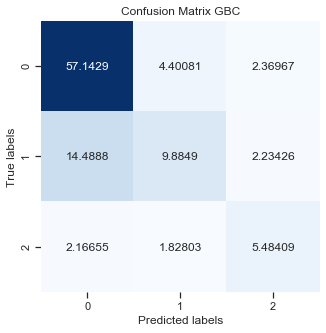

In [287]:
fig, ax = plt.subplots(figsize=(5,5))
sns.heatmap(cm, annot=True, ax = ax, cmap='Blues', cbar=False, fmt='g')
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix GBC', fon); 
ax.xaxis.set_ticklabels(['0', '1', '2']); ax.yaxis.set_ticklabels(['0', '1', '2']);
plt.show()

## Análisis de las características mas importantes GBC

In [30]:
feature_importance = GBC.feature_importances_
features = np.array(train.columns)

In [39]:
features_analisis = pd.DataFrame(features, columns=['features'])
features_analisis['performance'] = feature_importance
features_analisis.sort_values('performance', ascending=False, inplace=True)

In [49]:
## creamos una funcion para limpiar los nombres de la columna features
def clean_features_names(df, column_name):
    df[column_name] = df[column_name].map(lambda x: x.split('log_feature_')[-1])
    df[column_name] = df[column_name].map(lambda x: x.split('severity_type_')[-1])
    df[column_name] = df[column_name].map(lambda x: x.split('event_type_')[-1])
    df[column_name] = df[column_name].map(lambda x: x.split('resource_type_')[-1])
    return df

In [53]:
features_analisis = clean_features_names(features_analisis, 'features')
best_features = features_analisis[features_analisis['performance']>1e-3]

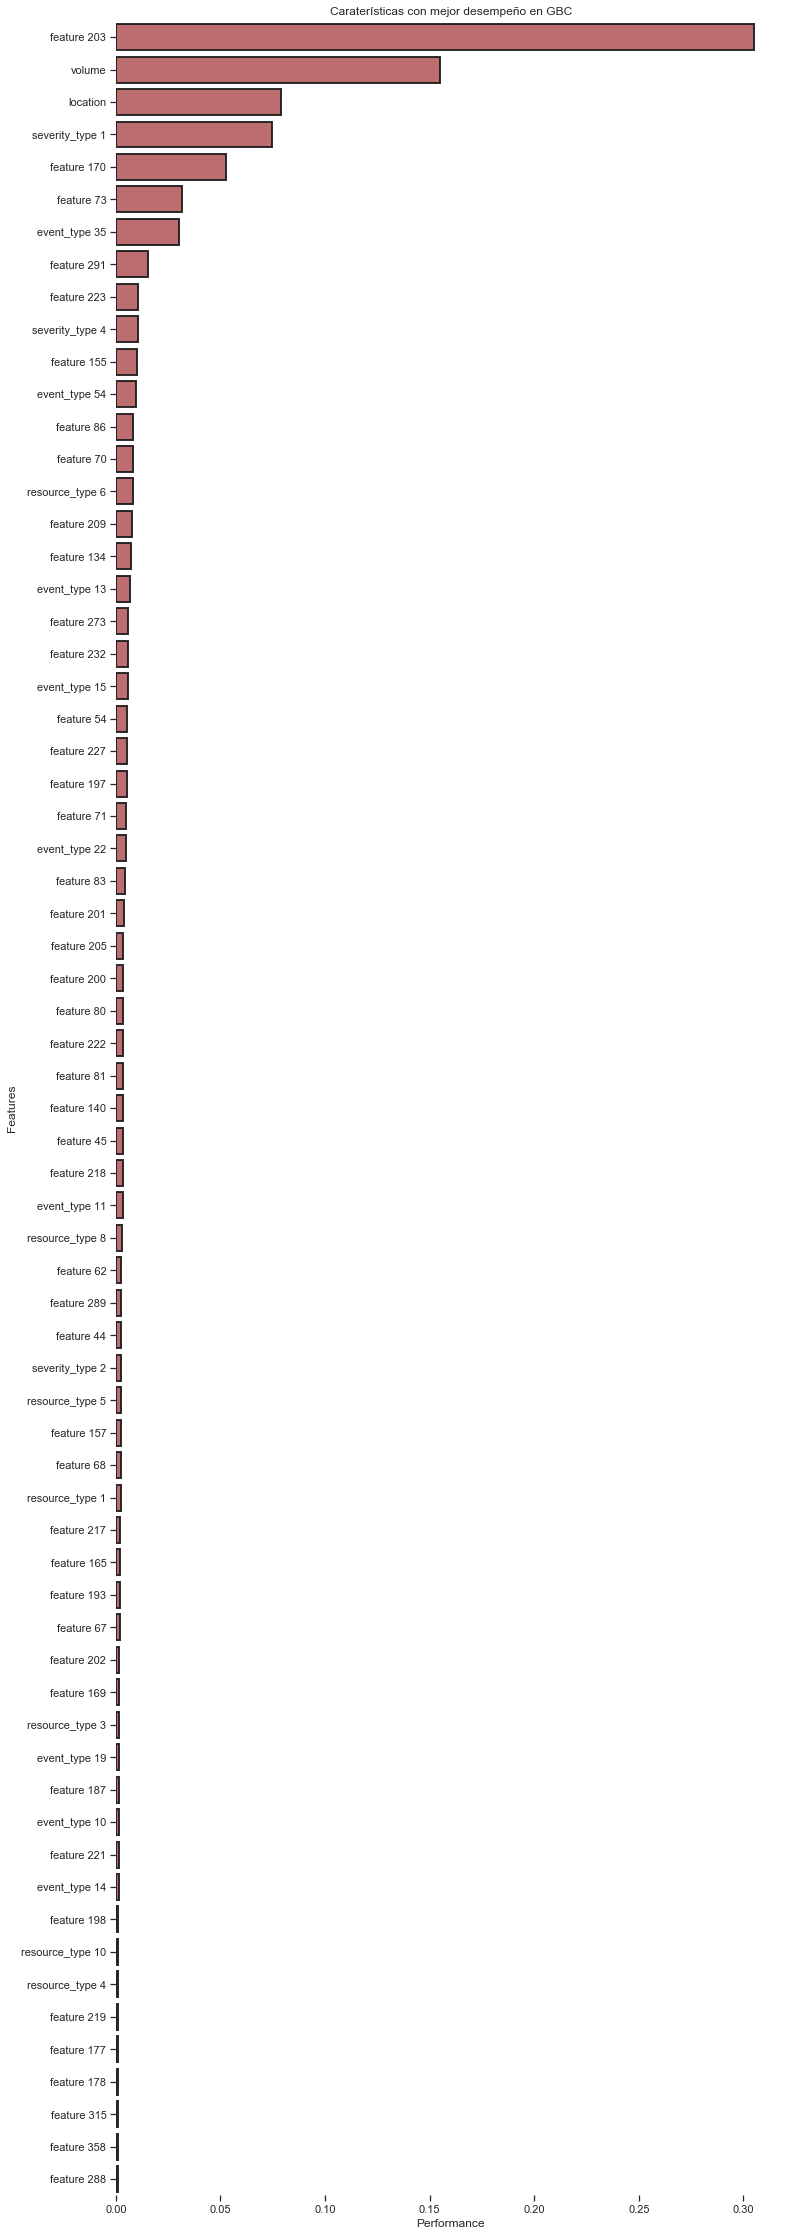

In [61]:
sns.set(style="ticks")
f, ax = plt.subplots(figsize=(12, 40))

kwargs = {'alpha':0.9, 'linewidth':2, 'edgecolor':'k'}
sns.barplot(x='performance', y = "features", data=best_features,
            label="index", color="r", **kwargs)


ax.set(ylabel="Features",
       xlabel="Performance")

sns.despine(left=True, bottom=True)

ax.set_title('Caraterísticas con mejor desempeño en GBC')
f.savefig('Best_features_GBC.png', dpi=100,
            bbox_inches='tight')
plt.show()

# Probemos el modelo en Kaggle

In [79]:
test_copy = test.copy()
test_copy = test_copy.drop(columns=['id'])

In [82]:
# Predecimos para test
y_submission = GBC.predict_proba(test_copy)

In [83]:
pred_df=pd.DataFrame(y_submission,columns=['predict_0', 'predict_1', 'predict_2'])
df_submission=pd.concat([test.id,pred_df],axis=1)
df_submission.head()

,id,predict_0,predict_1,predict_2
0,11066,0.972522,0.021666,0.005812
1,18000,0.281613,0.223546,0.494840
2,16964,0.970182,0.025449,0.004369
3,4795,0.787770,0.201784,0.010446
4,3392,0.302161,0.544188,0.153651


In [85]:
df_submission.to_csv('First_submission.csv', index=False)